In [1]:
from __future__ import print_function
import datetime
import time
from functools import reduce
import os

import pyarrow.parquet as parquet
import pandas as pd
import numpy as np
%matplotlib nbagg
import matplotlib.pyplot as plt
import copy

from fastset import FastSet

In [2]:
resultDirectory = 'Results/classads/UCSD/'
if not os.path.exists(resultDirectory):
    os.mkdir(resultDirectory)

In [3]:
startTime = datetime.datetime.now()

In [4]:
# Data collected from a spark query at CERN, in pandas pickle format
# CRAB jobs only have data after Oct. 2017
# ws = pd.read_pickle("data/working_set_day.pkl.gz")
# spark returns lists, we want to use sets
# ws['working_set_blocks'] = ws.apply(lambda x: set(x.working_set_blocks), 'columns')
# ws['working_set'] = ws.apply(lambda x: set(x.working_set), 'columns')

# Reading from working_set_day 
ws = parquet.read_table('data/working_set_day').to_pandas()
# spark returns lists, we want to use sets
ws['working_set_blocks'] = ws.apply(lambda x: FastSet(x.working_set_blocks), 'columns')

In [5]:
print(ws)

                  day SubmissionTool          input_campaign  d_data_tier_id  \
0        1.453162e+09          crab3                      HC             122   
1        1.453162e+09          crab3   RunIISpring15FSPremix           31224   
2        1.453248e+09          crab3                Run2015B               7   
3        1.453248e+09          crab3                Run2015D               9   
4        1.453334e+09          crab3                Run2015C               9   
5        1.453334e+09          crab3       RunIISpring15DR74              21   
6        1.453421e+09          crab2    RunIIFall15MiniAODv1           31224   
7        1.453421e+09          crab2       RunIISpring15DR74              21   
8        1.453421e+09          crab2  RunIISpring15MiniAODv2           31224   
9        1.453421e+09          crab3    RunIIFall15MiniAODv2           31224   
10       1.453507e+09          crab3                  HCtest             122   
11       1.453507e+09          crab3    

In [6]:
# Isolating the data associated with US sites
#US_ws = ws.loc[ws['SiteName'].str.startswith('T2_US')]
#print(US_ws)

In [7]:
#   DBS BLOCKS table schema:
#     BLOCK_ID NOT NULL NUMBER(38)
#     BLOCK_NAME NOT NULL VARCHAR2(500)
#     DATASET_ID NOT NULL NUMBER(38)
#     OPEN_FOR_WRITING NOT NULL NUMBER(38)
#     ORIGIN_SITE_NAME NOT NULL VARCHAR2(100)
#     BLOCK_SIZE NUMBER(38)
#     FILE_COUNT NUMBER(38)
#     CREATION_DATE NUMBER(38)
#     CREATE_BY VARCHAR2(500)
#     LAST_MODIFICATION_DATE NUMBER(38)
#     LAST_MODIFIED_BY VARCHAR2(500)
if not os.path.exists('data/block_size.npy'):
    blocksize = pd.read_csv("data/dbs_blocks.csv.gz", dtype='i8', usecols=(0,5), names=['block_id', 'block_size'])
    np.save('data/block_size.npy', blocksize.values)
    blocksize = blocksize.values
else:
    blocksize = np.load('data/block_size.npy')

# We'll be accessing randomly, make a dictionary
# blocksize = {v[0]:v[1] for v in blocksize}
# We'll be accessing randomly, make a fast lookup
bsort = np.argsort(blocksize[:,0])
bsize_index = blocksize[bsort, 0]
bsize_values = blocksize[bsort, 1]
def getsize(s):
    return bsize_values[np.searchsorted(bsize_index, s._set)].sum()
def getsetsize(s):
    return bsize_values[np.searchsorted(bsize_index, s)].sum()

In [8]:
# join the data tier definitions
datatiers = pd.read_csv('data/dbs_datatiers.csv').set_index('id')
ws['data_tier'] = datatiers.loc[ws.d_data_tier_id].data_tier.values

In [9]:
date_index = np.arange(np.min(ws.day.values//86400), np.max(ws.day.values//86400)+1)
date_index_ts = np.array(list(datetime.date.fromtimestamp(day*86400) for day in date_index))

In [10]:
tic = time.time()

is_crab = ws.SubmissionTool=='crab3'
is_miniaod = ws.data_tier.str.contains('MINIAOD')
is_us = ws.SiteName.str.match('T[23]_US')
is_ucsd = ws.SiteName.str.match('T[23]_US_UCSD')
ws_filtered = ws[is_crab & is_miniaod & is_ucsd]

blocks_day = []
for i, day in enumerate(date_index):
    today = (ws_filtered.day==day*86400)
    blocks_day.append(reduce(FastSet.union, ws_filtered[today].working_set_blocks, FastSet()))

print("Done assembling blocklists")

nrecords = np.zeros_like(date_index)
lifetimes = {
    '1w': 7,
    '1m': 30,
    '3m': 90,
    '6m': 120,
}
ws_size = {k: np.zeros_like(date_index) for k in lifetimes}
nrecalls = {k: np.zeros_like(date_index) for k in lifetimes}
recall_size = {k: np.zeros_like(date_index) for k in lifetimes}
previous = {k: FastSet() for k in lifetimes}

for i, day in enumerate(date_index):
    nrecords[i] = ws_filtered[(ws_filtered.day==day*86400)].size
    for key in lifetimes:
        current = reduce(FastSet.union, blocks_day[max(0,i-lifetimes[key]):i+1], FastSet())
        recall = current - previous[key]
        nrecalls[key][i] = len(recall)
        ws_size[key][i] = getsize(current)
        recall_size[key][i] = getsize(recall)
        previous[key] = current
    if i%30==0:
        print("Day ", i)

elapsed = time.time() - tic
print("Done in %.1f seconds" % elapsed)

Done assembling blocklists
Day  0
Day  30
Day  60
Day  90
Day  120
Day  150
Day  180
Day  210
Day  240
Day  270
Day  300
Day  330
Day  360
Day  390
Day  420
Day  450
Day  480
Day  510
Day  540
Day  570
Day  600
Day  630
Day  660
Day  690
Day  720
Day  750
Day  780
Day  810
Day  840
Day  870
Day  900
Day  930
Day  960
Day  990
Day  1020
Day  1050
Day  1080
Done in 34.3 seconds


In [11]:
# block_dict is a dictionary that holds the lists of blocks
# for all of the days for which the lists are nonzero
# Keys: Day
# Values: List of Blocks that were accessed on that Day
block_dict = {}
i=0
for el in blocks_day:
    i=i+1
    if len(el)>0:
        block_dict[i] = el

print("Merging daily block lists into one block set")
block_list = []
for i in range(len(blocks_day)):
    block_list += blocks_day[i]
# block_set is a set of all unique blocks.
# This can be used to isolate properties of individual blocks
# (e.g. how many times a block is accessed)
block_set = set(block_list)
print("Block Set Created")

Merging daily block lists into one block set
Block Set Created


In [12]:
# Rounds down the number to the multiple specified by the divisor
def round_down(num, divisor):
    return num - (num % divisor)

# Counts the frequencies of the quantities of blocks reused in an
# n day period (over all given time) where n = threshold
# Parameters: threshold - integer that determines the range of days (counted back from the given day)
#                         over which the blocks are counted
#             bucket - integer that determines "tolerance" for quantity of blocks such that
#                      the blocks are counted together (e.g. a bucket of 1000 means that a
#                      quantity of blocks less than 2000 would be counted as part of the
#                      1000 bucket because it is being rounded down)
def countBlockReuseFreq(threshold, bucket):
    block_reuse_dict = {}
    for day in block_dict:
        try:
            b = block_dict[day]
            i = day
            for i in range(day+1, day+threshold+1):
                b = b.union(block_dict[i])
            # Rounds down to the bin and checks to see if such a bin exists in the dictionary
            if round_down(len(b), bucket) in block_reuse_dict:
                block_reuse_dict[round_down(len(b), bucket)] += 1
            else:
                block_reuse_dict[round_down(len(b), bucket)] = 1
        except Exception as e:
            emptykey = e
            
    # Returns block_reuse_dict
    # Keys: Number of Blocks reused within the given threshold
    #       (organized by the given buckets)
    # Values: Frequencies of occurrence
    return block_reuse_dict

# Counts the frequencies of the total number of bytes reused in an
# n day period (over all given time) where n = threshold
# Parameters: threshold - integer that determines the range of days (counted back from the given day)
#                         over which the blocks are counted
#             bucket - integer that determines "tolerance" for bytes such that
#                      the bytes are counted together (e.g. a bucket of 1000 means that a
#                      size of less than 2000 bytes would be counted as part of the
#                      1000 byte bucket because it is being rounded down)
def countByteReuseFreq(threshold, bucket):
    byte_reuse_dict = {}
    for day in block_dict:
        try:
            b = block_dict[day]
            i = day
            for i in range(day+1, day+threshold+1):
                b = b.union(block_dict[i])
            # Counting the number of bytes in b
            bSize = 0
            bSize += getsize(b)
            # Rounds down to the bin and checks to see if such a bin exists in the dictionary
            if round_down(bSize, bucket) in byte_reuse_dict:
                # Adding the number of bytes into the given block into the current bin
                byte_reuse_dict[round_down(bSize, bucket)] += 1
            else:
                byte_reuse_dict[round_down(bSize, bucket)] = 1
        except Exception as e:
            emptykey = e
    
    # Returns byte_reuse_dict
    # Keys: Bytes reused within the given threshold (organized by the given buckets)
    # Values: Frequencies of occurrence
    return byte_reuse_dict

# Counts the frequencies of the total number of bytes reused in an
# n day period (over all given time) where n = threshold
# Returns them as a fraction: (Reused Bytes for a given day) / (Bytes accessed for a given day) 
# Parameters: threshold - integer that determines the range of days (counted back from the given day)
#                         over which the blocks are counted
#             bucket - integer that determines "tolerance" for percentage of byte usage 
#                      such that the percentage of byte usage are counted together (e.g. 
#                      a bucket of 0.05 means that a size of less than 0.10 would be counted as
#                      part of the 0.05 percentage bucket because it is being rounded down)
def countByteFracReuseFreq(threshold, bucket):
    byte_reuse_dict = {}
    for day in block_dict:
        try:
            b = block_dict[day]
            i = day
            tSize = 0
            # Populating tSize with the bytes accessed in the given day
            tSize = getsize(block_dict[day])
            for i in range(day+1, day+threshold+1):
                b = b.union(block_dict[i])
                # Counting the number of bytes accessed in the days within the threshold
                tSize += getsize(block_dict[i])
            # Counting the number of bytes in b
            bSize = 0
            bSize += getsize(b)
            percent = float(bSize)/float(tSize)
            # Rounds down to the bin and checks to see if such a bin exists in the dictionary
            if round_down(percent, bucket) in byte_reuse_dict:
                # Adding the number of bytes into the given block into the current bin
                byte_reuse_dict[round_down(percent, bucket)] += 1
            else:
                byte_reuse_dict[round_down(percent, bucket)] = 1
        except Exception as e:
            emptykey = e
    
    # Returns byte_reuse_dict
    # Keys: Bytes reused within the given threshold (organized by the given buckets)
    # Values: Frequencies of occurrence
    return byte_reuse_dict

In [13]:
endTime = datetime.datetime.now()
timeDifference = endTime-startTime
print("Total Runtime:")
print(timeDifference)

Total Runtime:
0:01:11.076999


In [14]:
# Finds the number of days total in working_set_day
print("Number of days in working_set_day:")
print(len(list(ws['day'].unique())))
# Finds the number of days covered in the dbs_blocks dataset
print("Number of days covered:")
print(len(date_index))
# Find the dates that are covered
print("Dates that are covered:")
print(str(date_index_ts[0]) 
      + ' to '
      + str(date_index_ts[len(date_index_ts)-1]))
# Finds the number of unique input_campaigns and outputs them
print("Number of unique input_campaigns:")
print(len(list(ws['input_campaign'].unique())))
# Finds the total number of jobs (assuming njobs is the number
# of jobs ran per row)
print("Number jobs total:")
print(ws['njobs'].sum())
# Finds the number of blocks total in the database
print("Total number of blocks in dbs_blocks:")
print(len(blocksize))
# Finds the total number of blocks accessed (in the given working set)
# in the database
accessed_block_set = set()
for block in ws['working_set_blocks']:
    accessed_block_set.update(block)
print("Total number of unique blocks accessed in the working set:")
print(len(accessed_block_set))
# Finds the total data across all blocks
print("Total number of bytes across all blocks:")
print(str(sum(blocksize)[1]/2e15) + " PB")

Number of days in working_set_day:
999
Number of days covered:
1089
Dates that are covered:
2016-01-07 to 2018-12-30
Number of unique input_campaigns:
319
Number jobs total:
604617621
Total number of blocks in dbs_blocks:
8935351
Total number of unique blocks accessed in the working set:
861526
Total number of bytes across all blocks:
180.63418737961337 PB


In [15]:
# Counts the number of blocks
def countBytesWorkingSet(bucket):
    accessed_block_set = set()
    size_dict = {}
    for block_set in ws['working_set_blocks']:
        accessed_block_set.update(block_set)
    for block in accessed_block_set:
        try: 
            bSize = getsize(FastSet({block}))
            if round_down(bSize, bucket) in accessed_block_set:
                size_dict[round_down(bSize, bucket)] += 1
            else:
                size_dict[round_down(bSize, bucket)] = 1
        except Exception as e:
            emptykey = e
    return size_dict

In [16]:
#fig, ax = plt.subplots(1,1)
#bucket = 1e3
#workingBlockDict = countBytesWorkingSet(bucket)
#ax.bar(list(workingBlockDict.keys()), list(workingBlockDict.values()), width=1)
#ax.set_title('Block Size Distribution')
#ax.set_xlabel('Blocksize (Bytes)')
#ax.set_ylabel('Number of Blocks')
#ax.set_ylim(0,None)
#ax.set_xlim(0,None)
#plt.savefig(resultDirectory + 'blockSizeDistribution.png')
#print(workingBlockDict)

In [17]:
campaign_list = list(ws['input_campaign'].unique())

# Finds the number of blocks for a given campaign
# Parameters: campaign - String detailing the name of the campaign
#                        to be searched
# Returns the number of blocks for a given campaign
def countCampaignBlocks(campaign):
    campaignBlockQuantity = 0
    campaignIndices = [i for i, 
                       x in enumerate(list(ws['input_campaign']))
                      if x == campaign]
    for i in campaignIndices:
        campaignBlockQuantity += len(ws['working_set_blocks'][i])
    return campaignBlockQuantity

# Finds the total number of bytes used in a given campaign
# Parameters: campaign - String detailing the name of the campaign
#                        to be searched
# Returns the total number of bytes used in a given campaign
def countCampaignBytes(campaign):
    campaignByteQuantity = 0
    campaignIndices = [i for i, 
                       x in enumerate(list(ws['input_campaign']))
                      if x == campaign]
    for i in campaignIndices:
        campaignByteQuantity += getsize(ws['working_set_blocks'][i])
    return campaignByteQuantity

# Creating a dictionary of quantity of blocks per campaign
# Keys: Quantity of Blocks
# Values: Quantity of Campaigns that have that Quantity of Blocks
def campaignBlockSumDict(bucket):
    campaignBlockDict = {}
    for campaign in campaign_list:
        try: 
            campaignBlockQuantity = countCampaignBlocks(campaign)
            if (round_down(campaignBlockQuantity, bucket)) in campaignBlockDict:
                campaignBlockDict[round_down(campaignBlockQuantity, bucket)] += 1
            else:
                campaignBlockDict[round_down(campaignBlockQuantity, bucket)] = 1           
        except exception as e:
            emptykey = e
    return campaignBlockDict
            
# Creating a dictionary of bytes per campaign
# Keys: Bytes
# Values: Quantity of Campaigns that have that number of bytes
def campaignByteSumDict(bucket):
    campaignByteDict = {}
    for campaign in campaign_list:
        try: 
            campaignByteQuantity = countCampaignBytes(campaign)
            if (round_down(campaignByteQuantity, bucket)) in campaignByteDict:
                campaignByteDict[round_down(campaignByteQuantity, bucket)] += 1
            else:
                campaignByteDict[round_down(campaignByteQuantity, bucket)] = 1           
        except exception as e:
            emptykey = e
    return campaignByteDict

In [18]:
# Defining the directory in which
resultDirectory = 'Results/dbs_blocks/'
if not os.path.exists(resultDirectory):
    os.mkdir(resultDirectory)

<IPython.core.display.Javascript object>


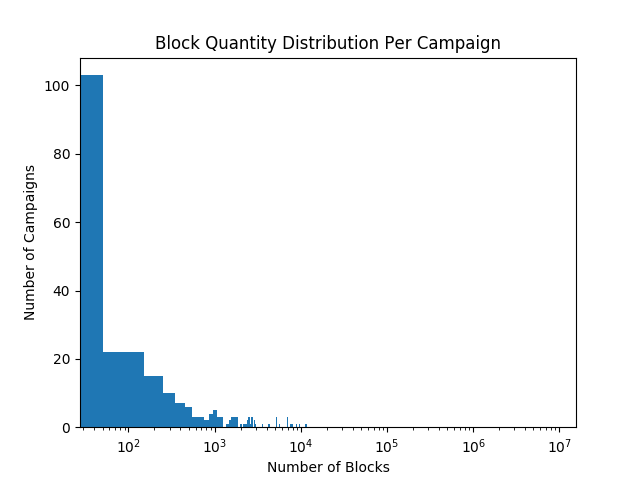

In [19]:
fig, ax = plt.subplots(1,1)
bucket = 100
campaignBlockDict = campaignBlockSumDict(bucket)
ax.bar(list(campaignBlockDict.keys()), list(campaignBlockDict.values()), width=1e2)
ax.set_title('Block Quantity Distribution Per Campaign')
ax.set_xscale('log')
ax.set_xlabel('Number of Blocks')
ax.set_ylabel('Number of Campaigns')
ax.set_ylim(0,None)
plt.savefig(resultDirectory + 'blockQuantityPerCampaign.png')

<IPython.core.display.Javascript object>


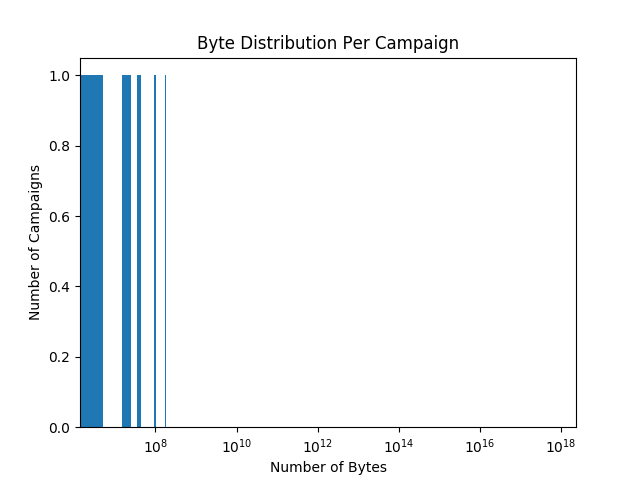

In [20]:
fig, ax = plt.subplots(1,1)
bucket = 2e7
campaignByteDict = campaignByteSumDict(bucket)
ax.bar(campaignByteDict.keys(), campaignByteDict.values(), width=1e7)
ax.set_title('Byte Distribution Per Campaign')
ax.set_xscale('log')
ax.set_xlabel('Number of Bytes')
ax.set_ylabel('Number of Campaigns')
ax.set_ylim(0,None)
plt.savefig(resultDirectory + 'bytesPerCampaign.png')

In [21]:
print(list(campaignByteDict.values()))
print(list(campaignByteDict.keys()))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[69176760000000.0, 1220974960000000.0, 299

<IPython.core.display.Javascript object>


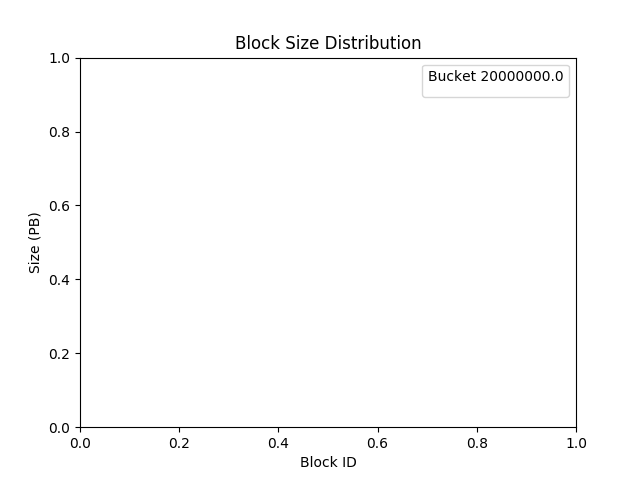

No handles with labels found to put in legend.


In [22]:
# Transposing the blocksize np array to be plotted
blocksizeT = np.transpose(blocksize)

fig, ax = plt.subplots(1,1)
#ax.bar(blocksizeT[0], blocksizeT[1], width=10)
#ax.bar(blocksizeT[0], blocksizeT[1])
ax.set_title('Block Size Distribution')
ax.legend(title='Bucket ' + str(bucket))
ax.set_ylabel('Size (PB)')
ax.set_xlabel('Block ID')
ax.set_ylim(0, None)
ax.set_xlim(0, None)
plt.savefig(resultDirectory + 'blockSizeDistribution.png')

In [23]:
# Counts quantity of unique blocks reused in an n-day period
# Parameters: threshold - integer that determines the range of
#                         days over which the blocks are counted
# Returns: A dictionary where: Keys - Dates
#                              Values - Set of unique blocks accessed
#                                       on the given date
def accessedBlockDict(threshold):
    accessed_block_dict = {}
    for day in block_dict:
        try: 
            # b is the set of all blocks accessed more than once 
            # within the n-day period
            b = block_dict[day].set()
            unique_set = block_dict[day].set()
            # t_block_set is the set of all blocks accessed in the n-day
            # time period
            t_block_set = copy.deepcopy(b)
            for i in range(day+1, day+threshold+1):
                t_block_set.update(block_dict[i])
                unique_set = unique_set.difference(block_dict[i])
            # unique_block_set is the set of all blocks accessed only once
            # in the n-day period
            b = t_block_set.difference(unique_set)
            accessed_block_dict[day] = unique_set
        except Exception as e:
            emptykey = e
    return accessed_block_dict

# Counts total quantity of blocks accessed in an n-day period
# Parameters: threshold - integer that determines the range of
#                         days over which the blocks are counted
# Returns: A dictionary where: Keys - Dates
#                              Values - Set of total blocks accessed
#                                       on the given date
def totalBlockDict(threshold):
    total_block_dict = {}
    for day in block_dict:
        try: 
            b = block_dict[day].set()
            # t_block_set is the set of all blocks accessed in the n-day
            # time period
            t_block_set = copy.deepcopy(b)
            for i in range(day+1, day+threshold+1):
                t_block_set.update(block_dict[i])
            total_block_dict[day] = t_block_set
        except Exception as e:
            emptykey = e
    return total_block_dict

# Tracks total quantity of blocks accessed in an n-day period
# and counts the number of blocks dropped for a given day step
# Parameters: threshold - integer that determines the range of
#                         days over which the blocks are counted
# Returns: A dictionary where: Keys - Dates
#                              Values - Set of blocks dropped
#                                       on the given date
def droppedBlocksDict(threshold):
    dropped_block_dict = {}
    prevOccurred = False
    prev = set()
    for day in block_dict:
        try: 
            # b is the set of blocks accessed in the previous day
            b = block_dict[day].set()
            # t_block_set is the set of all blocks accessed in the n-day
            # time period
            t_block_set = copy.deepcopy(b)
            for i in range(day+1, day+threshold+1):
                t_block_set.update(block_dict[i])
            if (prevOccurred):
                dropped_block_dict[day] = prev.difference(t_block_set.intersection(prev))
                prev.clear()
                prev.update(t_block_set)
            else:
                prev.clear()
                prev.update(t_block_set)
            prevOccurred = True
        except Exception as e:
            emptykey = e
    return dropped_block_dict

# Tracks total quantity of blocks accessed in an n-day period
# and counts the number of blocks gained for a given day step
# Parameters: threshold - integer that determines the range of
#                         days over which the blocks are counted
# Returns: A dictionary where: Keys - Dates
#                              Values - Set of blocks gained
#                                       on the given date
def gainedBlocksDict(threshold):
    gained_block_dict = {}
    prevOccurred = False
    prev = set()
    for day in block_dict:
        try: 
            # b is the set of blocks accessed in the previous day
            b = block_dict[day].set()
            # t_block_set is the set of all blocks accessed in the n-day
            # time period
            t_block_set = copy.deepcopy(b)
            for i in range(day+1, day+threshold+1):
                t_block_set.update(block_dict[i])
            if (prevOccurred):
                gained_block_dict[day] = t_block_set.difference(t_block_set.intersection(prev))
                prev.clear()
                prev.update(t_block_set)
            else:
                prev.clear()
                prev.update(t_block_set)
            prevOccurred = True
        except Exception as e:
            emptykey = e
    return gained_block_dict

In [24]:
accessed_block_dict = accessedBlockDict(14)
total_block_dict = totalBlockDict(14)
dropped_block_dict = droppedBlocksDict(14)
gained_block_dict = gainedBlocksDict(14)

In [25]:
print("Dropped Blocks: "+ str([len(x) for x in list(dropped_block_dict.values())[0:6]]))
print("Gained Blocks: " + str([len(x) for x in list(gained_block_dict.values())[0:6]]))
print("Total Blocks: " + str([len(x) for x in list(total_block_dict.values())[0:6]]))
print("Delta: " + str([len(x)-len(y) for x,y in zip(list(gained_block_dict.values())[0:6],list(dropped_block_dict.values())[0:6])]))

Dropped Blocks: [20, 333, 57, 89, 70, 78]
Gained Blocks: [54, 224, 95, 101, 66, 55]
Total Blocks: [2972, 3006, 2897, 2935, 2947, 2943]
Delta: [34, -109, 38, 12, -4, -23]


<IPython.core.display.Javascript object>


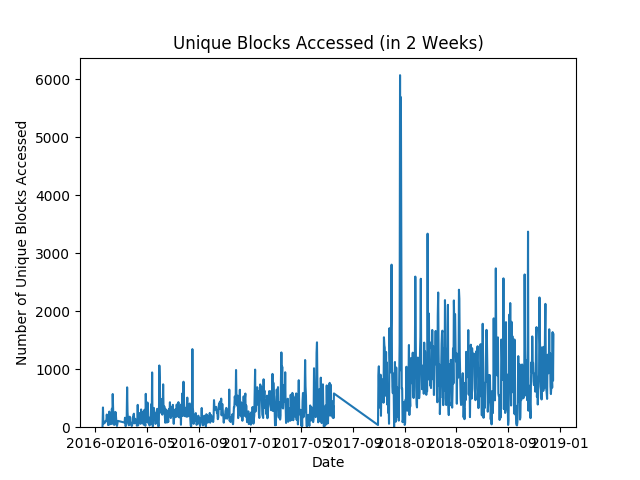

/usr/local/lib/python3.5/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


In [26]:
fig, ax = plt.subplots(1,1)
plt.rcParams["figure.figsize"] = (10,5)

dateList = []
for day in accessed_block_dict.keys():
    dateList.append(date_index_ts[day])
    
uniqueBlockQuantityList = []
for blockSet in accessed_block_dict.values():
    uniqueBlockQuantityList.append(len(list(blockSet)))
    
ax.plot(dateList, uniqueBlockQuantityList)
ax.set_title('Unique Blocks Accessed (in 2 Weeks)')
ax.set_ylabel('Number of Unique Blocks Accessed')
ax.set_xlabel('Date')
ax.set_ylim(0, None)
plt.savefig(resultDirectory + 'uniqueBlockAccessed2Weeks.png')

<IPython.core.display.Javascript object>


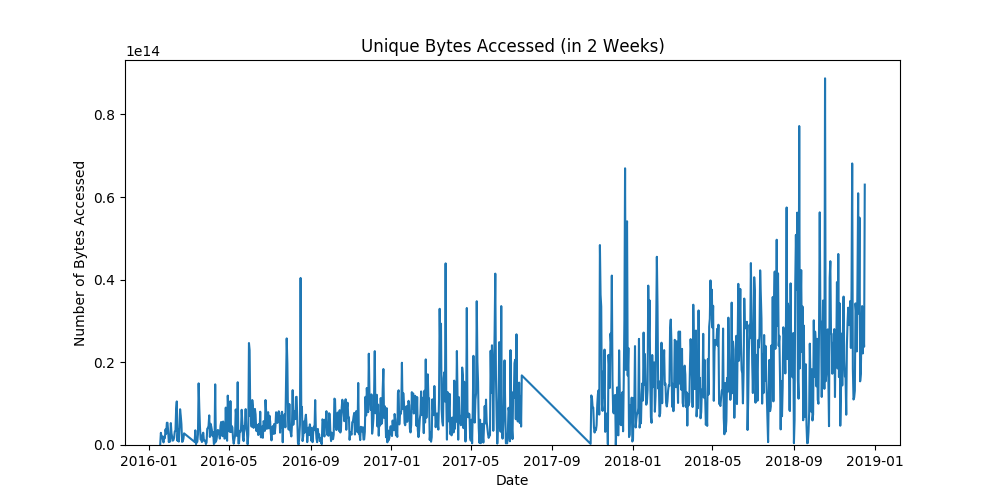

In [27]:
fig, ax = plt.subplots(1,1)

uniqueByteList = []
for blockSet in accessed_block_dict.values():
    bSize = getsize(FastSet(blockSet))
    uniqueByteList.append(bSize)
    
ax.plot(dateList, uniqueByteList)
ax.set_title('Unique Bytes Accessed (in 2 Weeks)')
ax.set_ylabel('Number of Bytes Accessed')
ax.set_xlabel('Date')
ax.set_ylim(0, None)
plt.savefig(resultDirectory + 'uniqueByteAccessed2Weeks.png')

<IPython.core.display.Javascript object>


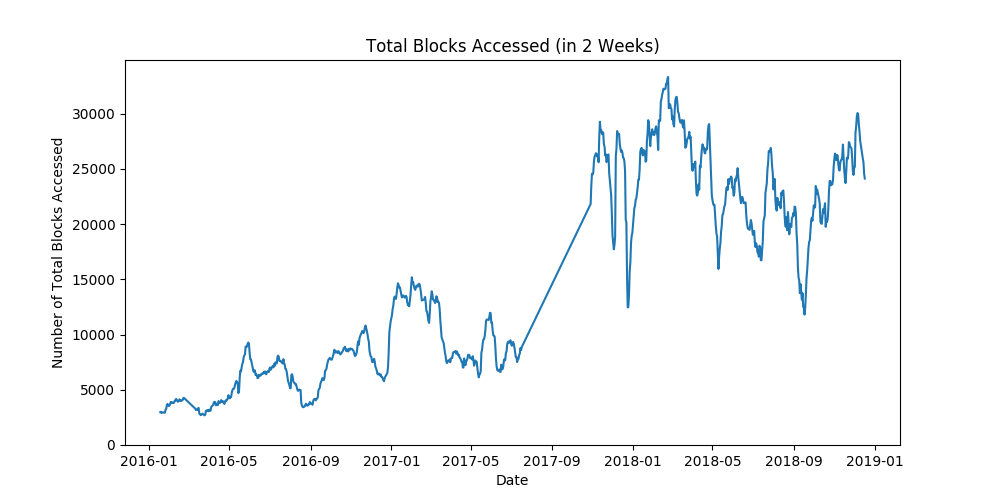

In [28]:
fig, ax = plt.subplots(1,1)

dateList = []
for day in accessed_block_dict.keys():
    dateList.append(date_index_ts[day])
    
totalBlockQuantityList = []
for blockSet in total_block_dict.values():
    totalBlockQuantityList.append(len(list(blockSet)))
    
ax.plot(dateList, totalBlockQuantityList)
plt.rcParams["figure.figsize"] = (10,5)
ax.set_title('Total Blocks Accessed (in 2 Weeks)')
ax.set_ylabel('Number of Total Blocks Accessed')
ax.set_xlabel('Date')
ax.set_ylim(0, None)
plt.savefig(resultDirectory + 'totalBlockAccessed2Weeks.png')

<IPython.core.display.Javascript object>


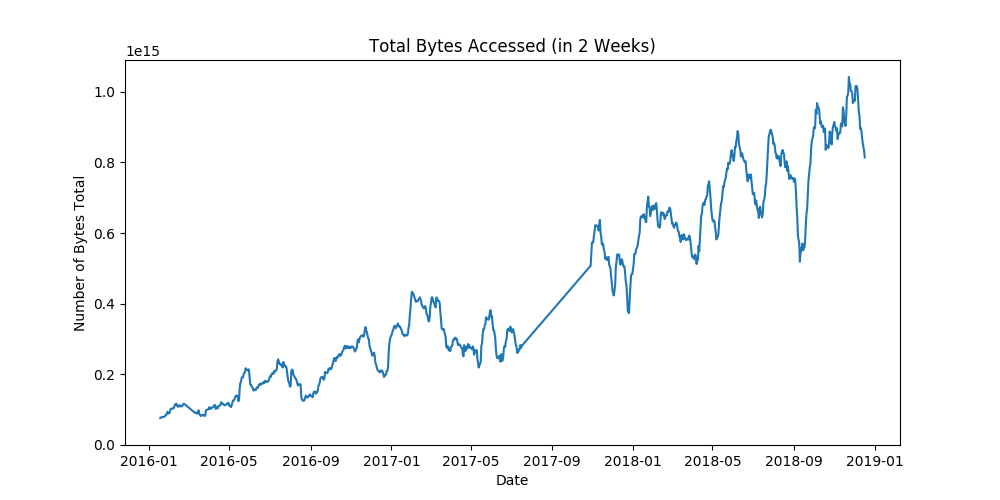

In [29]:
fig, ax = plt.subplots(1,1)

totalByteList = []
for blockSet in total_block_dict.values():
    bSize = getsize(FastSet(blockSet))
    totalByteList.append(bSize)
    
ax.plot(dateList, totalByteList)
ax.set_title('Total Bytes Accessed (in 2 Weeks)')
ax.set_ylabel('Number of Bytes Total')
ax.set_xlabel('Date')
ax.set_ylim(0, None)
plt.savefig(resultDirectory + 'totalByteTotal2Weeks.png')

<IPython.core.display.Javascript object>


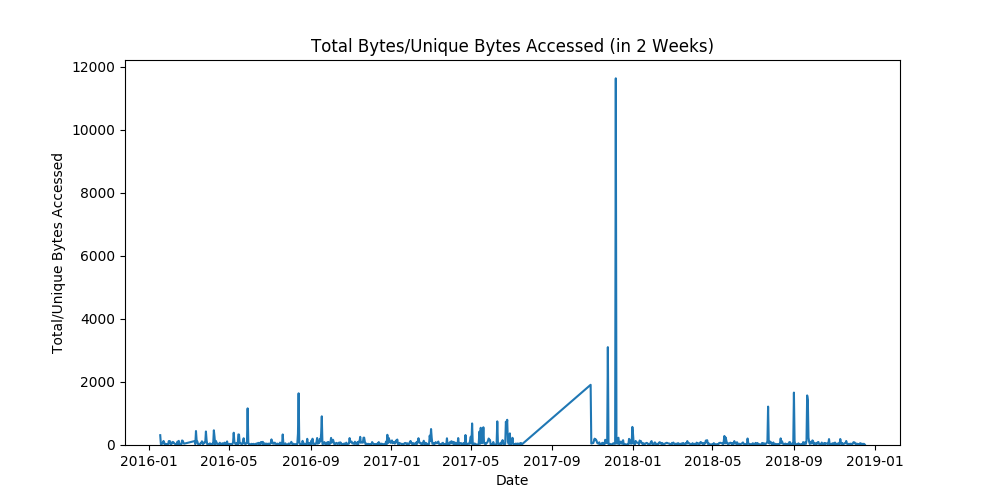

In [30]:
fig, ax = plt.subplots(1,1)

totalUniqueByteRatioList = []
for i in range(0, len(total_block_dict.values())):
    tSize = getsize(FastSet(list(total_block_dict.values())[i]))
    aSize = getsize(FastSet(list(accessed_block_dict.values())[i]))
    totalUniqueByteRatioList.append(tSize/aSize)
for blockSet in total_block_dict.values():
    bSize = getsize(FastSet(blockSet))
    totalByteList.append(bSize)
    
ax.plot(dateList, totalUniqueByteRatioList)
ax.set_title('Total Bytes/Unique Bytes Accessed (in 2 Weeks)')
ax.set_ylabel('Total/Unique Bytes Accessed')
ax.set_xlabel('Date')
ax.set_ylim(0, None)
plt.savefig(resultDirectory + 'totalUniqueByteRatio2Weeks.png')

<IPython.core.display.Javascript object>


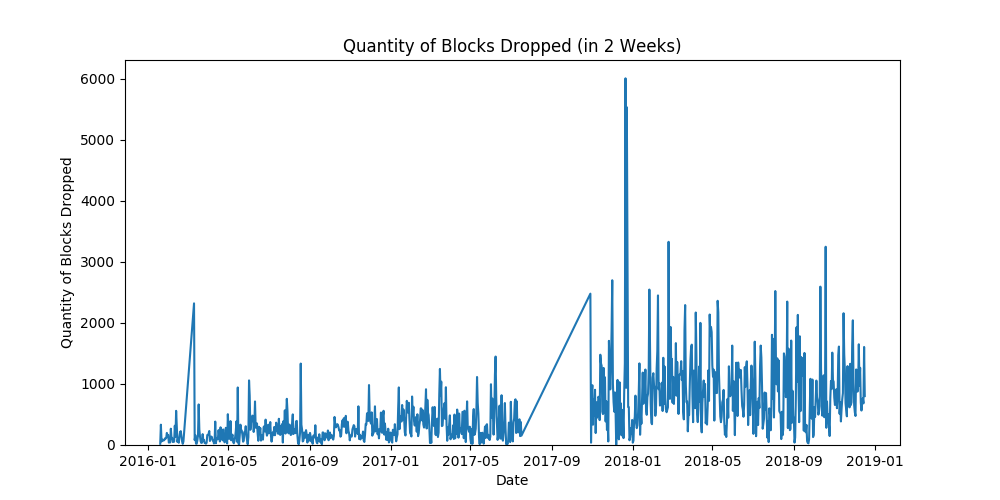

In [31]:
fig, ax = plt.subplots(1,1)

dateList = []
for day in dropped_block_dict.keys():
    dateList.append(date_index_ts[day])
    
droppedBlockQuantityList = []
for blockSet in dropped_block_dict.values():
    droppedBlockQuantityList.append(len(list(blockSet)))

    
ax.plot(dateList, droppedBlockQuantityList)
ax.set_title('Quantity of Blocks Dropped (in 2 Weeks)')
ax.set_ylabel('Quantity of Blocks Dropped')
ax.set_xlabel('Date')
ax.set_ylim(0, None)
plt.savefig(resultDirectory + 'droppedBlockQuantity2Weeks.png')

<IPython.core.display.Javascript object>


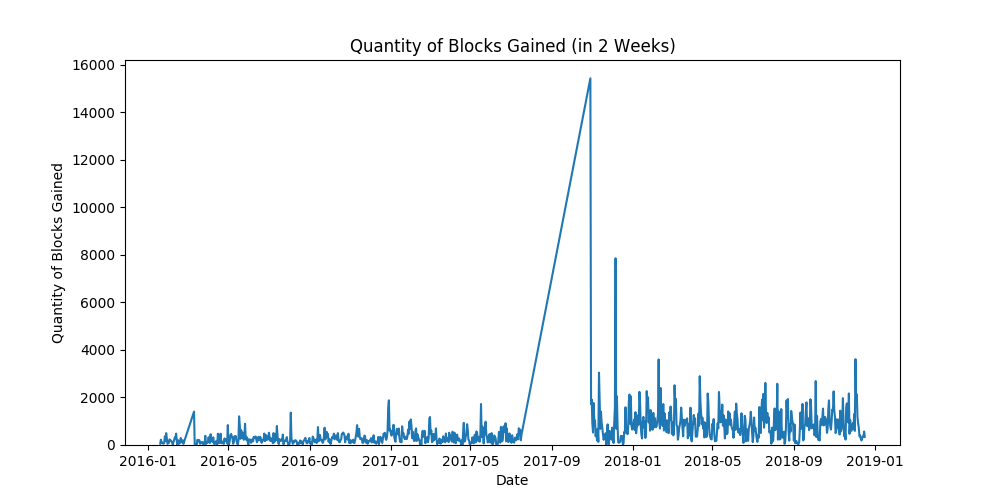

In [32]:
fig, ax = plt.subplots(1,1)

dateList = []
for day in gained_block_dict.keys():
    dateList.append(date_index_ts[day])
    
gainedBlockQuantityList = []
for blockSet in gained_block_dict.values():
    gainedBlockQuantityList.append(len(list(blockSet)))

    
ax.plot(dateList, gainedBlockQuantityList)
ax.set_title('Quantity of Blocks Gained (in 2 Weeks)')
ax.set_ylabel('Quantity of Blocks Gained')
ax.set_xlabel('Date')
ax.set_ylim(0, None)
plt.savefig(resultDirectory + 'gainedBlockQuantity2Weeks.png')